**<h1><center>Introduction to Deep Learning based Perception for Autonomous Driving</center></h1>**
<h4><center>Due: Dec 04, 2023 23:59 (GMT+3)</center></h4>

Computer vision (CV) is the field of study that deals with how computers can gain high-level understanding from digital images or videos. Your task for this question is to classify scenes according to their contexts by using simple machine learning algorithms developed for CV problems on scene images.

Your dataset consist of scene images from 4 contexts. Images of each context is stored under separate folders in the compressed file given to you.  The dataset has been processed in such a way that each class has approximately 2500 samples.

Download the dataset from the following link:
<br>
https://drive.google.com/file/d/1vXbTtm-PlTQPO-zN443Ehr7EsYuIoer_/view?usp=share_link
<br>

Libraries that are required in this question is given in the following code cell.

In [33]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# To Read Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
# To Interpret results & obtain plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# You could add your own libraries form Python Standard Library in this cell. Any other external libraries are not allowed.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loader 

An important part of such a task is to implement your own data loader. In this midterm, a partial loader is provided to you. This loader is going to be based on a base class named "Dataset", provided in PyTorch library. You need to complete the code below to create your custom "SceneDataset" class which will be able to load your dataset. Implement the functions whose proptotypes are given. Follow the TODO notes below. You have to divide the files into three sets as <b>train (70%)</b>,
<b>validation (10%)</b> and **test (20%)** sets.  These non-overlapping splits, which are subsets of SceneDataset, should be retrieved using the "get_dataset" function.


In [34]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from PIL import Image

class SceneDataset(Dataset):
    def __init__(self, data_path, transform=None):

        self.data_path = data_path
        self.classes = ['forest', 'glacier', 'mountain', 'sea']
        self.data = self.load_data()

        total_samples = len(self.data)
        train_size = int(0.7 * total_samples)
        val_size = int(0.1 * total_samples)
        test_size = total_samples - train_size - val_size

        # Split dataset
        self.train_data = self.data[:train_size]
        self.val_data = self.data[train_size:train_size + val_size]
        self.test_data = self.data[train_size + val_size:]

        self.transform = transform

    def load_data(self):
        data = []
        for idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_path, class_name)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                data.append({'file_path': file_path, 'class': idx})
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        if index < len(self.train_data):
            sample = self.train_data[index]
        elif index < len(self.train_data) + len(self.val_data):
            sample = self.val_data[index - len(self.train_data)]
        else:
            sample = self.test_data[index - len(self.train_data) - len(self.val_data)]

        file_path = sample['file_path']
        image = Image.open(file_path).convert('RGB')

        _x = self.transform(image) if self.transform else image
        _y = sample['class']

        return _x, _y




In [35]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from PIL import Image
def get_dataloaders(root, train_batchsize, test_batchsize):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = SceneDataset(data_path=os.path.join(root, 'data'), transform=transform)

    train_sampler = SubsetRandomSampler(range(len(dataset.train_data)))
    val_sampler = SubsetRandomSampler(range(len(dataset.train_data), len(dataset.train_data) + len(dataset.val_data)))
    test_sampler = SubsetRandomSampler(range(len(dataset.train_data) + len(dataset.val_data), len(dataset.data)))

    train_dataloader = DataLoader(dataset, batch_size=train_batchsize, sampler=train_sampler)
    val_dataloader = DataLoader(dataset, batch_size=test_batchsize, sampler=val_sampler)
    test_dataloader = DataLoader(dataset, batch_size=test_batchsize, sampler=test_sampler)

    return train_dataloader, val_dataloader, test_dataloader

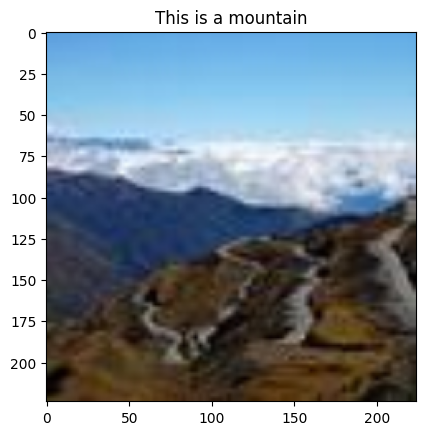

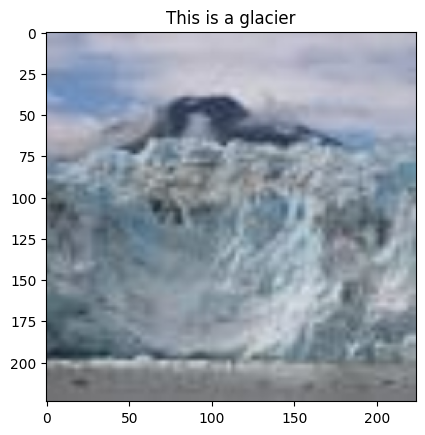

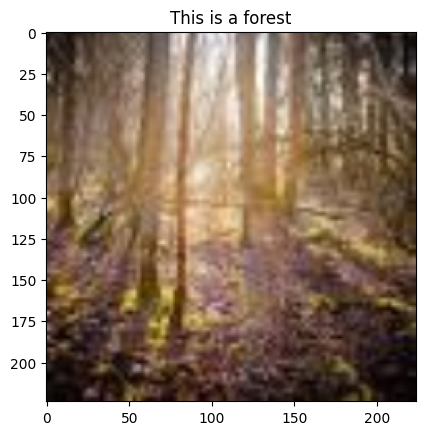

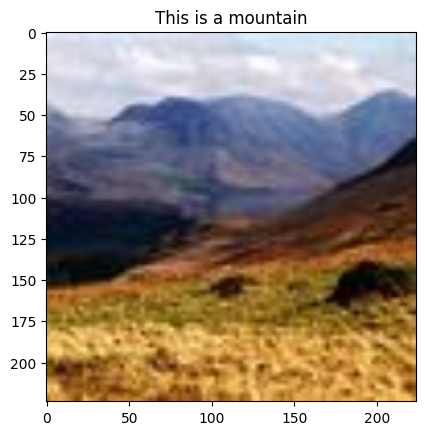

In [36]:
import matplotlib.pyplot as plt

classes = ['forest', 'glacier', 'mountain', 'sea']

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(root='/content/drive/MyDrive', train_batchsize=1, test_batchsize=1)

# Helper for visualization
def img_show(image, label):
    plt.figure()
    plt.title(f'This is a {label}')
    im = np.moveaxis(np.array(image), [0, 1, 2], [2, 0, 1])
    plt.imshow(im)
    plt.show()

# Visualize first 4 samples
for count, (image, label) in enumerate(train_dataloader):
    img_show(image[0], classes[int(label[0])])
    if count == 3:
        break


###Model Implementation

Now implement your CNN. ConvNet class will represent your convolutional neural network. Implement 3 layers of convolution:
<ul>
    <li>(1) 4 filters with size of 3 x 3 with stride 1 and padding 1, (2) ReLU </li>
    <li>(3) 8 filters with size of 3 x 3 with stride 1 and padding 1, (4) ReLU and (5) MaxPool 2 x 2 </li>
    <li>(6) 16 filters with size of 3 x 3 with stride 1 and padding 1, (7) ReLU and (8) MaxPool 2 x 2 </li>
</ul>

As the classifier layer, you need to add only one linear layer at the end of the network. You need to choose the appropriate input and output neuron sizes and the activation function for the dense layer.

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Classifier layer
        self.fc = nn.Linear(16 * 56 * 56, 10)

    def forward(self, x):
        # Forward pass
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


###Stochastic Gradient Descent 

####Training with SGD 

Train your model up to 300 epochs with properly processed inputs, i.e. call your "get_dataset" function. Use SGD as your optimizer. Tune your learning rate, weight decay. Do not add additional parameters to SGD. Save your best model as "best_cnn_sgd.pth". The best model should be selected based on validation dataset. You could use any measurement and/or metric to decide on the best model. 

During training, you need to plot two figures:
1. training loss and validation loss vs. epoch
2. training accuracy and validation accuracy vs. epoch <br>

Name your axes and plots properly.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# Set hyperparameters
max_epoch = 300
train_batch = 64
test_batch = 64
learning_rate = 0.001

# Get data loaders
train_loader, val_loader, test_loader = get_dataloaders('/content/drive/MyDrive', train_batch, test_batch)

# Initialize model, loss function, and optimizer
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-04)

# Lists to store training/validation losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Variables to track best validation accuracy
best_val_accuracy = 0.0
best_epoch = 0

# Training loop
for epoch in range(max_epoch):
    # Training
    model.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation - Evaluate less frequently for speed
    if epoch % 5 == 0:
        model.eval()
        total_val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save the model with the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_cnn_sgd.pth')

# Plot losses vs epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epoch + 1), train_losses, label='Train Loss')
plt.plot(range(1, max_epoch + 1, 5), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies vs epoch
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epoch + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, max_epoch + 1, 5), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.show()


KeyboardInterrupt: ignored

####Test with SGD 

Report the following for your best model on your test set which has not been seen by the model yet.
1. A heatmap for confusion matrix
2. Accuracy
3. Macro Precision
4. Macro Recall
5. F1 Score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.0
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 Score: 0.0


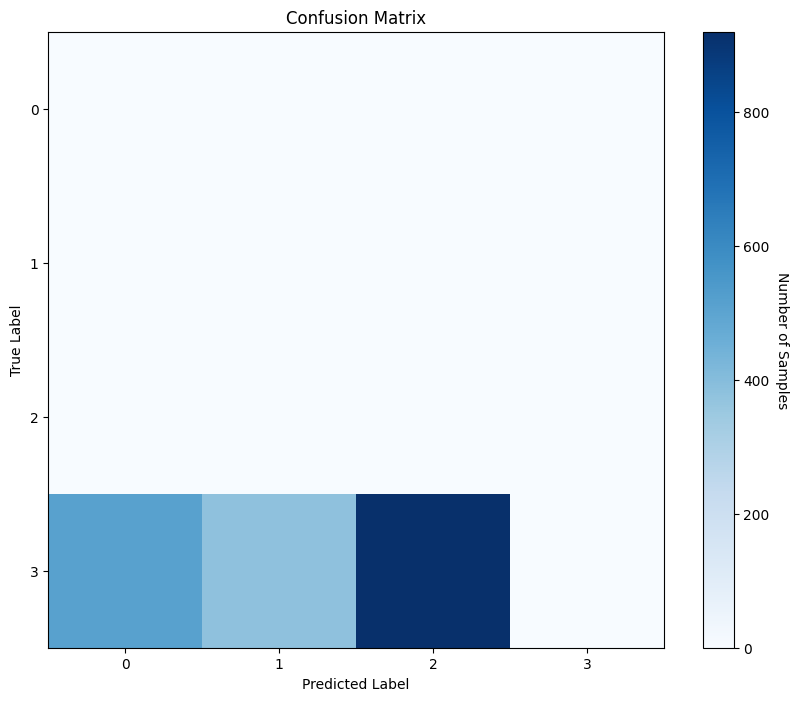

In [32]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Best model
best_path = "best_cnn_sgd.pth"
model = ConvNet()
model.load_state_dict(torch.load(best_path))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

acc = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("Accuracy:", acc)
print("Macro Precision:", precision)
print("Macro Recall:", recall)
print("Macro F1 Score:", f1)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(conf_matrix, cmap="Blues")

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))

cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('Number of Samples', rotation=-90, va="bottom")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


###Adam Optimizer 

Adam is an adaptive learning rate optimization algorithm that has been designed specifically for training deep neural networks. It was presented by Diederik Kingma from OpenAI and Jimmy Ba from the University of Toronto in their 2015 ICLR paper (poster) titled “Adam: A Method for Stochastic Optimization“.

Nowadays, most of machine learning frameworks, including tensorflow, Pytorch, and Keras, choose Adam as the default optimizer.

####Training with ADAM 

Train your model up to 300 epochs with properly processed inputs, i.e. call your "get_dataset". This time use Adam Optimizer as your optimizer. Tune your learning rate, weight decay. Save your best model as "best_cnn_adam.pth". The best model should be selected based on validation dataset. We could use any measurement and/or metric to decide on the best model for each network. However, we must explain your reasoning in your choice.

During training, you need to plot:
1. training loss and validation loss vs. epoch
2. training accuracy and validation accuracy vs. epoch <br>

Name your axes and plots properly.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

max_epoch = 10
train_batch = 32
test_batch = 32
learning_rate = 0.001  # You can try different learning rates within the given interval

# Assuming you have a get_dataset function to retrieve train, validation, and test dataloaders
train_dataloader, val_dataloader, test_dataloader = get_dataloaders('/content/drive/MyDrive', train_batch, test_batch)

# Initialize your network
model = ConvNet()

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-04)

# Start training
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(max_epoch):
    # Training
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

        val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save the model with the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_cnn_adam.pth')

# Plot losses vs epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, max_epoch + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies vs epoch
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epoch + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, max_epoch + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.show()


####Test with ADAM 

Report the following for your best model on your test set which has not been seen by the model yet.
1. A heatmap for confusion matrix
2. Accuracy
3. Macro Precision
4. Macro Recall
5. F1 Score


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

best_path = "best_cnn_adam.pth"
model = ConvNet()
model.load_state_dict(torch.load(best_path))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

acc = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("Accuracy:", acc)
print("Macro Precision:", precision)
print("Macro Recall:", recall)
print("Macro F1 Score:", f1)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(conf_matrix, cmap="Blues")

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))

cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('Number of Samples', rotation=-90, va="bottom")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


###Transfer Learning 

Instead of training CNNs from scratch, you can use pretrained models and apply them to your task. Transfer learning is a machine learning technique where you can reuse a pretrained machine learning model as a starting point for your own task. 

####Training with Transfer Learning 

Get pretrained ResNet18 model from torchvision.models and finetune your model up to 20 epochs with properly processed inputs, i.e. call your "get_dataset". This time use transfer learning. Tune your learning rate, weight decay. Save your best model as "best_cnn_transfer.pth". The best model should be selected based on validation dataset. You could use any measurement and/or metric to decide on the best model for each network. 

During training, you need to plot two figures:
1. training loss and validation loss vs. epoch
2. training accuracy and validation accuracy vs. epoch <br>

Name your axes and plots properly.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt

max_epoch = 20
train_batch = 32
test_batch = 32
learning_rate = 0.001
weight_decay = 1e-4

train_dataloader, val_dataloader, test_dataloader = get_dataloaders('/content/drive/MyDrive', train_batch, test_batch)

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(max_epoch):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

        val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_cnn_transfer.pth')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, max_epoch + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot accuracies vs epoch
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epoch + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, max_epoch + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.show()


####Test for Transfer Learning 

Report the following for your best model on your test set which has not been seen by the model yet.
1. A heatmap for confusion matrix
2. Accuracy
3. Macro Precision
4. Macro Recall
5. F1 Score

Discuss figures that you have plotted in the previous section, your test results and algorithm complexity with maximum 200 words.

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load the best transfer learning model
best_path = "best_cnn_transfer.pth"
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))  # Change output layer according to your output classes
model.load_state_dict(torch.load(best_path))
model.eval()

# Initialize variables for metrics
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate accuracy
acc = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Calculate precision, recall, and f1 score
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Print metrics
print("Accuracy:", acc)
print("Macro Precision:", precision)
print("Macro Recall:", recall)
print("Macro F1 Score:", f1)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(conf_matrix, cmap="Blues")

# Show all ticks
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))

# Label with color scale
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('Number of Samples', rotation=-90, va="bottom")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Answers:
# Transfer learning is the use of features of a previously trained model as a starting point for a new task.
# The advantages of this method include increasing performance on a new task with limited data, fast training processes, generalization ability,
# and the ability to use meaningful features of previously learned models.
# Especially for deep learning models, transfer learning offers a more efficient way than training a model from scratch.
